<h1>Build and train models</h1>

## Workshop overview

In this workshop, you will go through a complete machine learning process. You will use the ["AI4I 2020 Predictive Maintenance Dataset" from the UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset) , which contains information about machine failures, to train a regression model that predicts whether a machine will fail based on input data.

In this module, you will perform data exploration, data preprocessing, and model training in a familiar JupyterLab notebook environment in SageMaker Studio. In module 2 you will deploy a [inference pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/inference-pipelines.html) behind an endpoint. The inference pipeline will consist of a Feature Transformer and an XGBoost model. Finally, in module 3, you will create a pipeline for a complete machine learning development process using [SageMaker Pipelines](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html).

## In this notebook...

You will explore the data and use SKLearn Feature Transformers to preprocess the data. You then build and train an XGBoost logistic regression model and test it. You will use the SageMaker [@remote decorator](https://docs.aws.amazon.com/sagemaker/latest/dg/train-remote-decorator.html) to scale data processing and model training as Amazon SageMaker Training jobs.


If you are not familiar with Jupyter notebooks: Run the code cells in this notebook one by one. You can use Jupyter environment shortcuts such as Shift + Enter to run the current cell and move the cursor to the next cell.

Read the notes between the code cells to understand what the notebook is doing and observe the output from each cell.

## Environment set up 

Let's get started by installing the requirements.

In [1]:
%pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 113.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 147.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 91.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.7/149.7 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 20.7 MB/s eta 0:00:00
  Attempting uninsta

In [2]:
# # Restart kernel
# import IPython
# IPython.Application.instance().kernel.do_shutdown(True)

In [3]:
%load_ext autoreload
%autoreload 2

[SageMaker Distribution images](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-distribution.html) include popular libraries for machine learning and data science.

In [4]:
import pandas
import xgboost
import sklearn

print(f"Pandas version: {pandas.__version__}")
print(f"XGBoost version: {xgboost.__version__}")
print(f"SKLearn version: {sklearn.__version__}")

Pandas version: 2.1.4
XGBoost version: 1.7.6
SKLearn version: 1.3.2


Install the seaborn data visulization library.

In [5]:
%pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 24.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Lets load and set some required variables

In [6]:
%store -r 

%store

try:
    initialized
except NameError:    
    print("[ERROR] YOU HAVE TO RUN 00-start-here notebook   ")

Stored variables and their in-db values:
bucket_name                   -> 'sagemaker-us-east-1-164342431904'
bucket_prefix                 -> 'sagemaker-us-east-1-164342431904/amzn'
domain_id                     -> 'd-ctulbmd27zmn'
initialized                   -> True
mlflow_arn                    -> 'arn:aws:sagemaker:us-east-1:164342431904:mlflow-t
mlflow_name                   -> 'mlflow-d-ctulbmd27zmn'
project_prefix                -> 'amzn'
region                        -> 'us-east-1'
sm_role                       -> 'arn:aws:iam::164342431904:role/service-role/Amazo
space_name                    -> 'jupyterlab-space'
user_profile_name             -> 'default-user'


In [7]:
from time import gmtime, strftime

# Mlflow (replace these values with your own, if needed)
project_prefix = project_prefix
tracking_server_arn = mlflow_arn
experiment_name = f"{project_prefix}-sm-pipelines-experiment"
run_name=f"run-{strftime('%d-%H-%M-%S', gmtime())}"

In [8]:
config_yaml = f"""
SchemaVersion: '1.0'
SageMaker:
  PythonSDK:
    Modules:
      RemoteFunction:
        # role arn is not required if in SageMaker Notebook instance or SageMaker Studio
        # Uncomment the following line and replace with the right execution role if in a local IDE
        # RoleArn: <replace the role arn here>
        S3RootUri: s3://{bucket_prefix}
        InstanceType: ml.m5.xlarge
        Dependencies: ./requirements.txt
        IncludeLocalWorkDir: true
        PreExecutionCommands:
        - "sudo chmod -R 777 /opt/ml/model"
        CustomFileFilter:
          IgnoreNamePatterns:
          - "data/*"
          - "models/*"
          - "*.ipynb"
          - "__pycache__"

"""

print(config_yaml, file=open('config.yaml', 'w'))
print(config_yaml)


SchemaVersion: '1.0'
SageMaker:
  PythonSDK:
    Modules:
      RemoteFunction:
        # role arn is not required if in SageMaker Notebook instance or SageMaker Studio
        # Uncomment the following line and replace with the right execution role if in a local IDE
        # RoleArn: <replace the role arn here>
        S3RootUri: s3://sagemaker-us-east-1-164342431904/amzn
        InstanceType: ml.m5.xlarge
        Dependencies: ./requirements.txt
        IncludeLocalWorkDir: true
        PreExecutionCommands:
        - "sudo chmod -R 777 /opt/ml/model"
        CustomFileFilter:
          IgnoreNamePatterns:
          - "data/*"
          - "models/*"
          - "*.ipynb"
          - "__pycache__"




The Amazon SageMaker Python SDK supports setting of default values for AWS infrastructure primitive types, such as instance types, Amazon S3 folder locations, and IAM roles. You can override the default locations of these files by setting the `SAGEMAKER_USER_CONFIG_OVERRIDE` environment variables for the user-defined configuration file paths.

In [9]:
import os

# Use the current working directory as the location for SageMaker Python SDK config file
os.environ["SAGEMAKER_USER_CONFIG_OVERRIDE"] = os.getcwd()

Download the dataset from the UCI website.

In [10]:
import urllib
import os

input_data_dir = 'data/'
if not os.path.exists(input_data_dir):
    os.makedirs(input_data_dir)
input_data_path = os.path.join(input_data_dir, 'predictive_maintenance_raw_data_header.csv')
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv"
urllib.request.urlretrieve(dataset_url, input_data_path)

('data/predictive_maintenance_raw_data_header.csv',
 <http.client.HTTPMessage at 0x7f0d7e0fb010>)

# Exploratory data analysis

In this section, you will perform a fairly simple analysis to examine the shape and distribution of the raw data, summary statistics of the features, frequency counts of the labels, and the relationships between pairs of features. Feel free to spend more time on data analysis if you wish.

Determine the number of samples (rows) and features (columns) in the dataset.

In [11]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv(input_data_path)

print('The shape of the dataset is:', df.shape)

The shape of the dataset is: (10000, 14)


Preview the first 10 rows.

In [12]:
df.head(10)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
5,6,M14865,M,298.1,308.6,1425,41.9,11,0,0,0,0,0,0
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,0,0,0,0,0
7,8,L47187,L,298.1,308.6,1527,40.2,16,0,0,0,0,0,0
8,9,M14868,M,298.3,308.7,1667,28.6,18,0,0,0,0,0,0
9,10,M14869,M,298.5,309.0,1741,28.0,21,0,0,0,0,0,0


Check the data types for each column and identify columns with missing values.

In [13]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


List the possible values for the "Machine failure" column and frequency of their occurence over the entire dataset.

In [14]:
df['Machine failure'].value_counts()

Machine failure
0    9661
1     339
Name: count, dtype: int64

Plot the target columns to visualise the distribution of values.

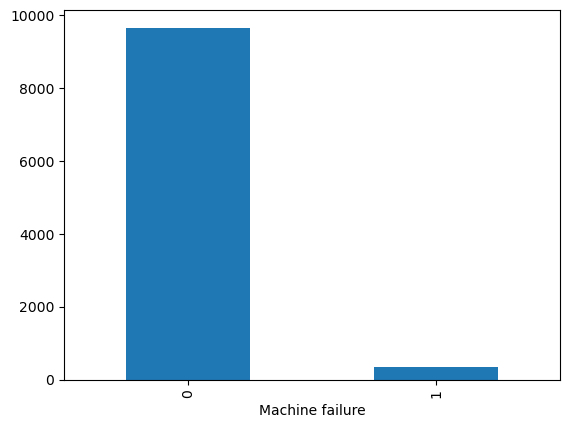

In [15]:
import matplotlib.pyplot as plt

df['Machine failure'].value_counts().plot.bar()
plt.show()

You will notice that the dataset is quite unbalanced. However, you are not going to balance it in this workshop.

In [16]:
# compute the count of unique values for colums in df
df.nunique()

UDI                        10000
Product ID                 10000
Type                           3
Air temperature [K]           93
Process temperature [K]       82
Rotational speed [rpm]       941
Torque [Nm]                  577
Tool wear [min]              246
Machine failure                2
TWF                            2
HDF                            2
PWF                            2
OSF                            2
RNF                            2
dtype: int64

Drop the attributes you are not interested in and keep only the numeric attributes.

In [17]:
df1 = df.sample(frac =.1)
df1 = df1.drop(['UDI', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1).select_dtypes(include='number')
df1.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
6136,300.9,310.8,1390,40.6,131,0
2593,298.9,308.5,1415,54.0,6,0
1268,298.0,309.5,1496,45.8,46,0
5952,300.7,310.8,1563,33.8,104,0
7774,300.3,311.5,1634,31.9,36,0


View the summary of the pre-processed dataset.

In [18]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 6136 to 103
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Air temperature [K]      1000 non-null   float64
 1   Process temperature [K]  1000 non-null   float64
 2   Rotational speed [rpm]   1000 non-null   int64  
 3   Torque [Nm]              1000 non-null   float64
 4   Tool wear [min]          1000 non-null   int64  
 5   Machine failure          1000 non-null   int64  
dtypes: float64(3), int64(3)
memory usage: 54.7 KB


Use a pair plot to spot correlations.

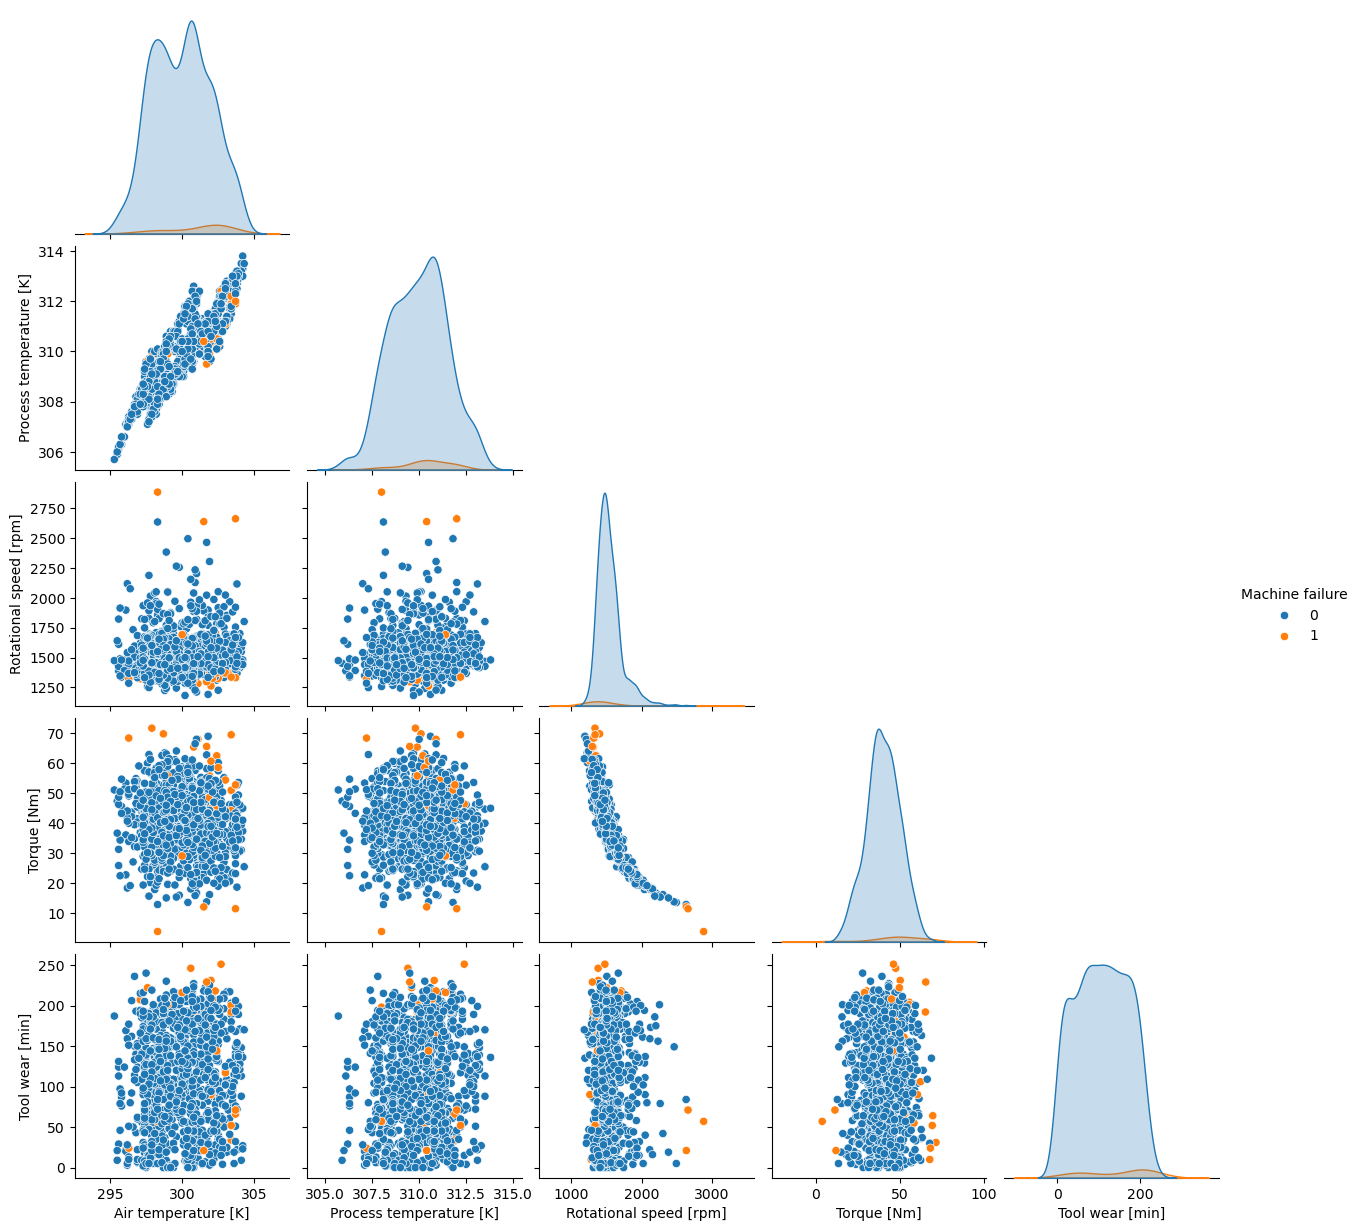

In [19]:
import seaborn
import matplotlib.pyplot as plt

seaborn.pairplot(df1, hue='Machine failure', corner=True)
plt.show()

To keep the data exploration step short during the workshop, no additional queries are included. However, feel free to explore the dataset more if you wish.

## Feature Engineering

### Data Processing

You will run data pre-processing in the `preprocess` function in the following cell. This function performs one-hot encoding of the relevant categorical columns and fills in the NaN values based on domain knowledge. It then splits the dataset into training, validation, and test datasets, fits the featurizer model, and transforms the datasets. The function returns the model and the output datasets, and saves the serialized model to the file system.

The following cell annotates the `preprocess` function with the [@remote decorator](https://docs.aws.amazon.com/sagemaker/latest/dg/train-remote-decorator.html) to run the Python function as a SageMaker job without requiring any other modifications to the function code. Feel free to comment out the remote decorator in the cells below to seamlesssly move from running the function remotely via SageMaker Training to local execution. If you comment out the decorator to run the function locally, you will need to run this command in the terminal to give permission to the output directory where the function will save the models: `sudo chmod -R 777 /opt/ml/model`. You don't need to run this command if you leave the remote decorator in, since the `config.yaml` file runs that command before executing the training job.

The code also uses [SageMaker Managed Warm Pools](https://docs.aws.amazon.com/sagemaker/latest/dg/train-warm-pools.html) by setting the `keep_alive_period_in_seconds` parameter. SageMaker Managed Warm Pools let you retain and reuse provisioned infrastructure after the completion of a job to reduce latency for repetitive workloads, such as iterative experimentation or running many jobs consecutively. Subsequent training jobs that match specified parameters run on the retained warm pool infrastructure, which speeds up start times by reducing the time spent provisioning resources. Please note that Managed Warm Pools might not be enabled for your AWS Account; in such case, although the code will still work, you might not see lower latencies for the subsequent iterations.

In [20]:
import os
import joblib

from sagemaker.workflow.execution_variables import ExecutionVariables
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


from sagemaker.remote_function import remote

import mlflow
import pandas as pd

@remote(keep_alive_period_in_seconds=3600, job_name_prefix=f"{project_prefix}-sm-btd-preprocess")
def preprocess(df, df_source: str, experiment_name: str):
    
    mlflow.set_tracking_uri(tracking_server_arn)
    mlflow.set_experiment(experiment_name)    
    
    with mlflow.start_run(run_name=f"Preprocessing") as run:            
        mlflow.autolog()
        
        columns = ['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure']
        cat_columns = ['Type']
        num_columns = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
        target_column = 'Machine failure'                    
        df = df[columns]

        mlflow.log_input(
            mlflow.data.from_pandas(df, df_source, targets=target_column),
            context="DataPreprocessing",
        )
        
        training_ratio = 0.8
        validation_ratio = 0.1
        test_ratio = 0.1
    
        X = df.drop(target_column, axis=1)
        y = df[target_column]
    
        print(f'Splitting data training ({training_ratio}), validation ({validation_ratio}), and test ({test_ratio}) sets ')
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=0, stratify=y)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio/(validation_ratio+training_ratio), random_state=2, stratify=y_train)
    
        # Apply transformations
        transformer = ColumnTransformer(transformers=[('numeric', StandardScaler(), num_columns),
                                                      ('categorical', OneHotEncoder(), cat_columns)],
                                        remainder='passthrough')
        featurizer_model = transformer.fit(X_train)
        X_train = featurizer_model.transform(X_train)
        X_val = featurizer_model.transform(X_val)
    
        print(f'Shape of train features after preprocessing: {X_train.shape}')
        print(f'Shape of validation features after preprocessing: {X_val.shape}')
        print(f'Shape of test features after preprocessing: {X_test.shape}')
        
        y_train = y_train.values.reshape(-1)
        y_val = y_val.values.reshape(-1)
        
        print(f'Shape of train labels after preprocessing: {y_train.shape}')
        print(f'Shape of validation labels after preprocessing: {y_val.shape}')
        print(f'Shape of test labels after preprocessing: {y_test.shape}')
    
        model_file_path="/opt/ml/model/sklearn_model.joblib"
        os.makedirs(os.path.dirname(model_file_path), exist_ok=True)
        joblib.dump(featurizer_model, model_file_path)

    return X_train, y_train, X_val, y_val, X_test, y_test, featurizer_model

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Fetched defaults config from location: /home/sagemaker-user/amazon-sagemaker-build-train-deploy/01_build_and_train
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.Dependencies
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.PreExecutionCommands
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.InstanceType
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.S3RootUri


The function returns multiple values, including the training, validation, and test features and labels, and the featurizer model.

In [21]:
X_train, y_train, X_val, y_val, X_test, y_test, featurizer_model = preprocess(df=df, 
                                                                              df_source=dataset_url, 
                                                                              experiment_name=experiment_name)

2024-10-18 12:00:42,855 sagemaker.remote_function INFO     Serializing function code to s3://sagemaker-us-east-1-164342431904/amzn/amzn-sm-btd-preprocess-2024-10-18-12-00-42-855/function
2024-10-18 12:00:42,919 sagemaker.remote_function INFO     Serializing function arguments to s3://sagemaker-us-east-1-164342431904/amzn/amzn-sm-btd-preprocess-2024-10-18-12-00-42-855/arguments
2024-10-18 12:00:43,305 sagemaker.remote_function INFO     Copied user workspace to '/tmp/tmpiskpuadj/temp_workspace/sagemaker_remote_function_workspace'
2024-10-18 12:00:43,308 sagemaker.remote_function INFO     Copied dependencies file at './requirements.txt' to '/tmp/tmpiskpuadj/temp_workspace/sagemaker_remote_function_workspace/requirements.txt'
2024-10-18 12:00:43,309 sagemaker.remote_function INFO     Generated pre-execution script from commands to '/tmp/tmpiskpuadj/temp_workspace/sagemaker_remote_function_workspace/pre_exec.sh'
2024-10-18 12:00:43,349 sagemaker.remote_function INFO     Successfully created

2024-10-18 12:00:43 Starting - Starting the training job...
2024-10-18 12:01:02 Starting - Preparing the instances for training...
2024-10-18 12:01:30 Downloading - Downloading input data...
2024-10-18 12:01:45 Downloading - Downloading the training image......
2024-10-18 12:03:11 Training - Training image download completed. Training in progress...INFO: CONDA_PKGS_DIRS is set to '/opt/ml/sagemaker/warmpoolcache/sm_remotefunction_user_dependencies_cache/conda/pkgs'
INFO: PIP_CACHE_DIR is set to '/opt/ml/sagemaker/warmpoolcache/sm_remotefunction_user_dependencies_cache/pip'
INFO: Bootstraping runtime environment.
2024-10-18 12:03:17,911 sagemaker.remote_function INFO     The job is running on non-root user: sagemaker-user. Adding write permissions to the following job output directories: ['/opt/ml/output', '/opt/ml/model', '/tmp'].
2024-10-18 12:03:17,911 sagemaker.remote_function INFO     Executing 'sudo chmod -R 777 /opt/ml/output /opt/ml/model /tmp'.
2024-10-18 12:03:17,924 sagemaker

Analyze the featurizer model structure.

In [22]:
featurizer_model

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric', StandardScaler(),
                                 ['Air temperature [K]',
                                  'Process temperature [K]',
                                  'Rotational speed [rpm]', 'Torque [Nm]',
                                  'Tool wear [min]']),
                                ('categorical', OneHotEncoder(), ['Type'])])

Analyzing a few rows from preprocessed training dataset shows that the categorical features have been one-hot encoded. If you wish, you can perform more analysis to make sure there are no NaN values in the dataset.


In [23]:
import pandas as pd
pd.DataFrame(X_train).head(10)

,0,1,2,3,4,5,6,7
0,0.647088,0.467287,-0.191472,0.720195,-0.536976,0.0,1.0,0.0
1,-0.149803,-0.607399,-0.353343,-0.002390,0.230714,0.0,1.0,0.0
2,2.091452,2.280819,1.125822,-1.186626,-0.474308,0.0,1.0,0.0
3,-1.893001,-1.883589,-0.130072,-0.353647,-1.100993,0.0,1.0,0.0
4,1.892229,1.944980,0.310886,-0.484113,-0.615312,0.0,0.0,1.0
5,-1.345139,-1.144742,-1.508765,2.065005,0.168045,0.0,1.0,0.0
6,-0.099997,-0.607399,-1.023153,1.673605,-1.586675,0.0,0.0,1.0
7,-0.647860,-0.002889,-0.107745,-0.193072,1.405749,0.0,0.0,1.0
8,0.497671,0.064279,0.109943,-0.745047,-1.696345,0.0,1.0,0.0
9,-0.896888,-1.346246,0.294141,-0.634652,-1.194996,0.0,0.0,1.0


## Model Training

In this section, you will use XGBoost to train a logistic regression model using the preprocessed data generated in the previous step. Again, you will use a standard Python function that accepts some of the XGBoost hyperparameters as input and returns the model.

In [24]:
# only required if you run locally
# !mkdir -p /opt/ml/model
# !sudo chmod -R 777 /opt/ml/model

In [25]:
import os
import xgboost
import numpy as np
import mlflow
from sagemaker.remote_function import remote

@remote(keep_alive_period_in_seconds=3600, job_name_prefix=f"{project_prefix}-sm-btd-train")
def train(X_train, y_train, X_val, y_val,
          eta=0.1, 
          max_depth=2, 
          gamma=0.0,
          min_child_weight=1,
          verbosity=0,
          objective='binary:logistic',
          eval_metric='auc',
          num_boost_round=5):

    print('Train features shape: {}'.format(X_train.shape))
    print('Train labels shape: {}'.format(y_train.shape))
    print('Validation features shape: {}'.format(X_val.shape))
    print('Validation labels shape: {}'.format(y_val.shape))        
    
    mlflow.set_tracking_uri(tracking_server_arn)
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run(run_name=f"Training") as run:               
        mlflow.autolog()
             
        # Creating DMatrix(es)
        dtrain = xgboost.DMatrix(X_train, label=y_train)
        dval = xgboost.DMatrix(X_val, label=y_val)
        watchlist = [(dtrain, "train"), (dval, "validation")]
    
        print('')
        print (f'===Starting training with max_depth {max_depth}===')
        
        param_dist = {
            "max_depth": max_depth,
            "eta": eta,
            "gamma": gamma,
            "min_child_weight": min_child_weight,
            "verbosity": verbosity,
            "objective": objective,
            "eval_metric": eval_metric
        }        
    
        xgb = xgboost.train(
            params=param_dist,
            dtrain=dtrain,
            evals=watchlist,
            num_boost_round=num_boost_round)
    
        predictions = xgb.predict(dval)
    
        print ("Metrics for validation set")
        print('')
        print (pd.crosstab(index=y_val, columns=np.round(predictions),
                           rownames=['Actuals'], colnames=['Predictions'], margins=True))
        
        rounded_predict = np.round(predictions)
    
        val_accuracy = accuracy_score(y_val, rounded_predict)
        val_precision = precision_score(y_val, rounded_predict)
        val_recall = recall_score(y_val, rounded_predict)
    
        print("Accuracy Model A: %.2f%%" % (val_accuracy * 100.0))            
        print("Precision Model A: %.2f" % (val_precision))
        print("Recall Model A: %.2f" % (val_recall))
        
        # Log additional metrics, next to the default ones logged automatically
        mlflow.log_metric("Accuracy Model A", val_accuracy * 100.0)
        mlflow.log_metric("Precision Model A", val_precision)
        mlflow.log_metric("Recall Model A", val_recall)
        
        from sklearn.metrics import roc_auc_score
    
        val_auc = roc_auc_score(y_val, predictions)
        
        print("Validation AUC A: %.2f" % (val_auc))
        mlflow.log_metric("Validation AUC A", val_auc)
    
        model_file_path="/opt/ml/model/xgboost_model.bin"
        os.makedirs(os.path.dirname(model_file_path), exist_ok=True)
        xgb.save_model(model_file_path)

    return xgb

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.Dependencies
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.PreExecutionCommands
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.InstanceType
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.S3RootUri


Running the training function will initiate a SageMaker training job because the function is decoarated with the @remote decorator.

In [ ]:
eta=0.3
max_depth=8

booster = train(X_train, y_train, X_val, y_val,
              eta=eta, 
              max_depth=max_depth)

2024-10-18 12:04:28,571 sagemaker.remote_function INFO     Serializing function code to s3://sagemaker-us-east-1-164342431904/amzn/amzn-sm-btd-train-2024-10-18-12-04-28-570/function
2024-10-18 12:04:28,641 sagemaker.remote_function INFO     Serializing function arguments to s3://sagemaker-us-east-1-164342431904/amzn/amzn-sm-btd-train-2024-10-18-12-04-28-570/arguments
2024-10-18 12:04:29,100 sagemaker.remote_function INFO     Copied user workspace to '/tmp/tmpuu_a_5nq/temp_workspace/sagemaker_remote_function_workspace'
2024-10-18 12:04:29,102 sagemaker.remote_function INFO     Copied dependencies file at './requirements.txt' to '/tmp/tmpuu_a_5nq/temp_workspace/sagemaker_remote_function_workspace/requirements.txt'
2024-10-18 12:04:29,103 sagemaker.remote_function INFO     Generated pre-execution script from commands to '/tmp/tmpuu_a_5nq/temp_workspace/sagemaker_remote_function_workspace/pre_exec.sh'
2024-10-18 12:04:29,143 sagemaker.remote_function INFO     Successfully created workdir a

2024-10-18 12:04:29 Starting - Starting the training job...
2024-10-18 12:04:45 Starting - Preparing the instances for training...
2024-10-18 12:05:23 Downloading - Downloading the training image.........
2024-10-18 12:06:49 Training - Training image download completed. Training in progress..INFO: CONDA_PKGS_DIRS is set to '/opt/ml/sagemaker/warmpoolcache/sm_remotefunction_user_dependencies_cache/conda/pkgs'
INFO: PIP_CACHE_DIR is set to '/opt/ml/sagemaker/warmpoolcache/sm_remotefunction_user_dependencies_cache/pip'
INFO: Bootstraping runtime environment.
2024-10-18 12:06:59,736 sagemaker.remote_function INFO     The job is running on non-root user: sagemaker-user. Adding write permissions to the following job output directories: ['/opt/ml/output', '/opt/ml/model', '/tmp'].
2024-10-18 12:06:59,736 sagemaker.remote_function INFO     Executing 'sudo chmod -R 777 /opt/ml/output /opt/ml/model /tmp'.
2024-10-18 12:06:59,750 sagemaker.remote_function INFO     Successfully unpacked workspace 

Display the information about the trained model.

In [ ]:
booster

### Using the models to generate predictions

Finally, you use the models for inference and evaluate model accuracy. The @remote decorator is commented out, because the function does not require additional processing power or memory. However, you can uncomment the first line to run the job remotely if you wish.

In [ ]:
# @remote(keep_alive_period_in_seconds=600, job_name_prefix=f"{project_prefix}-sm-btd-test")
def test(featurizer_model, booster, X_test, y_test):

    mlflow.start_run(run_name=f"Testing")
    mlflow.autolog()
    X_test = featurizer_model.transform(X_test)
    y_test = y_test.values.reshape(-1)

    dtest = xgboost.DMatrix(X_test, label=y_test)
    test_predictions = booster.predict(dtest)
    
    print ("===Metrics for Test Set===")
    print('')
    print (pd.crosstab(index=y_test, columns=np.round(test_predictions), 
                                     rownames=['Actuals'], 
                                     colnames=['Predictions'], 
                                     margins=True)
          )
    print('')

    rounded_predict = np.round(test_predictions)

    accuracy = accuracy_score(y_test, rounded_predict)
    precision = precision_score(y_test, rounded_predict)
    recall = recall_score(y_test, rounded_predict)
    
    print('')
    print("Accuracy Model A: %.2f%%" % (accuracy * 100.0))
    print("Precision Model A: %.2f" % (precision))
    print("Recall Model A: %.2f" % (recall))
    
    mlflow.log_metric("Accuracy Model A", accuracy * 100.0)
    mlflow.log_metric("Precision Model A", precision)
    mlflow.log_metric("Recall Model A", recall)

    from sklearn.metrics import roc_auc_score

    auc = roc_auc_score(y_test, test_predictions)
    
    print("AUC A: %.2f" % (auc))
    mlflow.log_metric("AUC A",auc)
    
    mlflow.end_run()

Test the trained model using the text features and labels.

In [ ]:
test(featurizer_model, booster, X_test, y_test)

2024/10/18 12:08:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/10/18 12:08:12 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.
2024/10/18 12:08:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/10/18 12:08:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.


===Metrics for Test Set===

Predictions  0.0  1.0   All
Actuals                    
0            961    5   966
1             10   24    34
All          971   29  1000


Accuracy Model A: 98.50%
Precision Model A: 0.83
Recall Model A: 0.71
AUC A: 0.94


## Star GitHub repository

In [ ]:
%%html

<a class="github-button" href="https://github.com/aws-samples/amazon-sagemaker-build-train-deploy" data-color-scheme="no-preference: light; light: light; dark: dark;" data-icon="octicon-star" data-size="large" data-show-count="true" aria-label="Star Amazon SageMaker secure MLOps on GitHub">Star</a>
<script async defer src="https://buttons.github.io/buttons.js"></script>

### Click this button above to bookmark this repository

### You have completed module 1
In this module, you built a featurizer model using SKLearn to preprocess the data. You also built and trained a regression model using XGBoost.

Proceed to module 2 to deploy the models on a SageMaker inference endpoint.